## Adaptive lengthscales for 2 Dimensional input

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

In [2]:
from ctf.functions2d import branin
Br = branin.Branin()
X1_domain = Br.domain[0]
X2_domain = Br.domain[1]

In [3]:
X1 = np.linspace(X1_domain[0], X1_domain[1],10)
X2 = np.linspace(X2_domain[0], X2_domain[1],10)

Xtt1, Xtt2 = np.meshgrid(X1, X2)
X_train = np.zeros(shape =(np.ravel(Xtt1).shape[0],2))
X_train[:, 0] = np.ravel(Xtt1) 
X_train[:, 1] = np.ravel(Xtt2)

In [4]:
Xtrain_mean = np.mean(X_train, 0)
Xtrain_std = np.std(X_train, 0)
X_train_norm = (X_train - Xtrain_mean) / Xtrain_std
Y_train = Br.cost(X_train.T)

/Users/piyushpandita/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


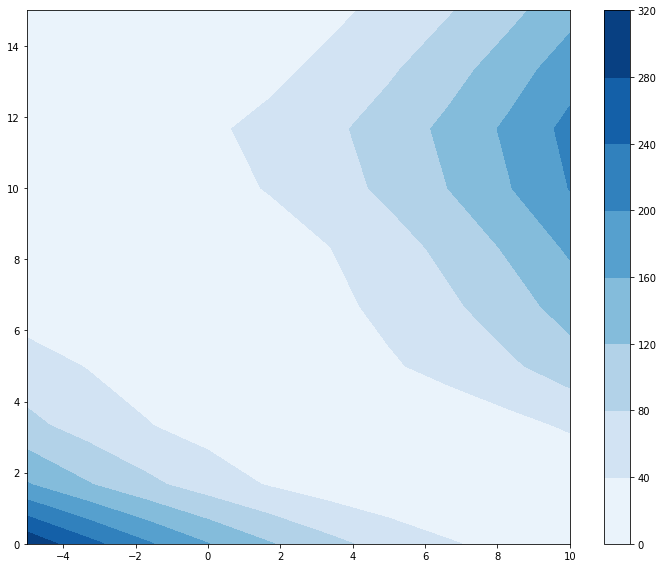

In [5]:
plt.figure(figsize=(10,8))
num_grid = X1.shape[0]
c = plt.contourf(X1, X2, Y_train.reshape((num_grid, num_grid), order='F'), cmap=plt.cm.Blues)
plt.colorbar(c)

In [6]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
k2 = gpflow.kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(X_train_norm, Y_train[:,None], k, nonstat)

In [7]:
# Lengthscale 1 GP priors 
#m.kern1.variance = 0.1
#m.kern1.variance.fixed = True
#m.kern1.lengthscales = 0.5
#m.kern1.lengthscales.fixed = True
m.kerns["ell0"].variance.prior = gpflow.priors.Gaussian(0, 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gaussian(0, 1.)
# Lengthscale 2 GP priors
#m.kern2.variance = 0.1
#m.kern2.variance.fixed = True
#m.kern2.lengthscales = 0.5
#m.kern2.lengthscales.fixed = True
m.kerns["ell1"].variance.prior = gpflow.priors.Gaussian(0, 1.)
m.kerns["ell1"].lengthscales.prior = gpflow.priors.Gaussian(0, 1.)

# Non stationary signal variance prior
# m.nonstat.signal_variance = 100
# m.nonstat.signal_variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gaussian(0, 1.)

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

In [8]:
import tensorflow as tf
m.optimize(maxiter=5000)

      fun: array([5124.33680493])
 hess_inv: <303x303 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.72579691e+02, -6.86028777e+03,  3.61892390e+02, -1.03409631e+02,
        1.36130540e+02, -6.39062063e+01, -3.19559128e+01, -3.65568456e+01,
       -1.52281491e+02, -3.89530117e+01, -2.16658326e+02, -4.75399369e+01,
       -2.48606256e+02, -1.48842857e+02, -1.72166844e+02,  1.06690641e+02,
       -1.61809720e+02,  5.16913491e+00, -3.82262417e+01, -2.21395032e+01,
       -6.34724610e+01,  1.69172091e+03,  1.00254220e+02,  7.80244644e+01,
        2.67212974e+01,  3.70835746e+01, -5.51503428e+00,  7.63137977e+01,
        1.49827987e+01,  4.46533039e+01, -1.13270261e+01,  4.61558958e+01,
       -2.39996573e+01,  1.02160256e+02,  3.23844276e+01, -1.71808822e+01,
        2.93659557e+01,  1.83573708e+01,  7.60637008e+00,  1.47715296e+01,
        1.38572254e+02,  5.06087223e+03, -1.85357531e+02,  5.72756221e+02,
       -7.72923228e+01,  2.43715074e+02, -1.80259273e+01,  1.93816082e

##  Sampling from the posterior using Hamiltonian Monte Carlo

In [9]:
samples = m.sample(20, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  92.0 %
burn-in sampling ended


## Visualizing inferred latent lengthscales 

In [10]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [11]:
X1t = np.linspace(X1_domain[0], X1_domain[1], 100)
X2t = np.linspace(X2_domain[0], X2_domain[1], 100)
X_test = np.zeros(shape =(X1t.shape[0],2))
X_test[:,0] = X1t
X_test[:,1] = X2t
X_testnorm = (X_test - Xtrain_mean) / Xtrain_std

In [12]:
print samples.shape

(20, 303)


In [13]:
mean_l1_mat = np.ndarray((samples.shape[0], X_train_norm.shape[0]))
var_l1_mat = np.ndarray((samples.shape[0], X_train_norm.shape[0]))
mean_l2_mat = np.ndarray((samples.shape[0], X_train_norm.shape[0]))
var_l2_mat = np.ndarray((samples.shape[0], X_train_norm.shape[0]))
sample_df = m.get_samples_df(samples)

In [14]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1, mean2, v2 = m.predict_l(X_train_norm)
    mean_l1_mat[i, :] = mean1[:, 0]
    var_l1_mat[i, :] = np.diag(v1)
    mean_l2_mat[i, :] = mean2[:, 0]
    var_l2_mat[i, :] = np.diag(v2)
# ml1, vl1, ml2, vl2 = m.predict_l(X_train_norm)

TypeError: an integer is required

In [ ]:
MeanL1 = np.exp(mean_l1_mat)
MeanL2 = np.exp(mean_l2_mat)
lowerl1 = np.exp(mean_l1_mat - 2 * np.sqrt(var_l1_mat))
upperl1 = np.exp(mean_l1_mat + 2 * np.sqrt(var_l1_mat))
lowerl2 = np.exp(mean_l2_mat - 2 * np.sqrt(var_l2_mat))
upperl2 = np.exp(mean_l2_mat + 2 * np.sqrt(var_l2_mat))
# LowerL1 = np.exp(lower1)
# UpperL1 = np.exp(upper1)

In [ ]:
min_idx = 0
max_idx = 10
for i in range(min_idx, max_idx):
    visualize_l(X1t, MeanL1[i, :], upperl1[i, :], lowerl1[i, :])

In [ ]:
for i in range(min_idx, max_idx):
    visualize_l(X2t, MeanL2[i, :], upperl2[i, :], lowerl2[i, :])

## Visualizing the predicted latent function

In [ ]:
def visualize_f(X1, X2, M):
    """
    Visualize 2D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    plt.figure(figsize=(10,8))
    num_grid = X1.shape[0]
    c = plt.contourf(X1, X2, M.reshape((num_grid, num_grid), order='F'), cmap=plt.cm.Blues)
    plt.colorbar(c)
#     line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    #plt.fill_between(Xgrid[:,0], L, U,
    #                 color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('$x1$')
    plt.ylabel('$x2$')
    return

In [ ]:
mean = []
var = []
sample_df = m.get_samples_df(samples)

In [ ]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(X_train_norm)
    mean.append(mean_f)
    var.append(var_f)
    

In [ ]:
X1 = np.linspace(X1_domain[0], X1_domain[1],10)
X2 = np.linspace(X2_domain[0], X2_domain[1],10)
for i in range(min_idx, max_idx):
    visualize_f(X1, X2, mean[i])